# AI for Healthcare Assignment 1
**Cornelius Yap**  
**1003358**

In [1]:
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [2]:
# This section need not be edited (It is intended to setup the working environment for tensorflow)

In [3]:
def config_gpu():
    #Configure Gpus
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [4]:
config_gpu()

1 Physical GPUs, 1 Logical GPUs


In [5]:
#Checkpoint 1: Define Training/Test data size and dimension and explain the rationale for your selection------------------------

## Section 3: Preprocessing the Dataset

#### Making sense of the dataset that we have

In [6]:
images = []
folder = os.path.join("Data")
img_widths = []
img_heights = []
total_images = 0
size = {}
for sub_folder in os.listdir(folder):
    if sub_folder == ".DS_Store":
        continue
    sub_path = os.path.join(folder, sub_folder)
    sub_folder_images = 0
    for filename in os.listdir(sub_path):
        img = Image.open(os.path.join(sub_path, filename))
        if img is not None:
            sub_folder_images += 1
            width, height = img.size
            if width not in img_widths:
                img_widths.append(width)
            if height not in img_heights:
                img_heights.append(height)
        else:
            print("Presence of None Images")
    size[sub_folder] = sub_folder_images
    print(f"{sub_folder} image count: {sub_folder_images}")
    total_images += sub_folder_images
print(f"We have a total of {total_images} in our dataset\n")

print(f"Our dataset contains images with the following widths: {img_widths}")
print(f"Our dataset contains images with the following heights: {img_heights}")
        
minimum_width = min(img_widths)
minimum_height = min(img_heights)

print(f"The minimum width is {minimum_width}")
print(f"The minimum height is {minimum_height}")


CNV image count: 1000
DME image count: 3000
DRUNSEN image count: 3000
NORMAL image count: 3000
We have a total of 10000 in our dataset

Our dataset contains images with the following widths: [768, 512, 1536, 1024, 384]
Our dataset contains images with the following heights: [496, 512]
The minimum width is 384
The minimum height is 496


#### Function to preprocess the data:

In [7]:
#Function to retrieve the images from the filenames and preprocess it
#
#Inputs:
#    filename - tensor string of the filepath to the image
#    label - python string of the true label for the image corresponding to the filename given
#    width -  int containing the resized width value 
#    height - int containing the resized height value
#
#Outputs:
#    img - tf.image of the processed image
#    label - encoded value of the true label of the image

def preprocess(filename,label, encoder, width = 0, height = 0):
    #Retrieve image
    image_string = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(image_string, channels=1) #channels set to 1 as it is greyscale
    #Normalise the pixel values from 0-255 to 0-1
    img = tf.image.convert_image_dtype(img, tf.float32)
    #Resize the image
    img = tf.image.resize(img, [height, width])
    #Encode the label
    encoded_label = encoder.transform([label])[0]
    return img, encoded_label

#Function to concatenate dataset
#Input: Python list containing tf.Dataset that needs to be merged
#Output: Merged tf.Dataset

def merge_dataset(dataset_list):
    for i in range(len(dataset_list)):
        if i == 0:
            merged_dataset = dataset_list[i]
        else:
            merged_dataset = merged_dataset.concatenate(dataset_list[i])
    return merged_dataset
    

#Function to split the dataset
#
#Inputs:
#    img_datasets - Python list containing images stored in tf.Dataset for each specific class
#    dataset_sizes - Python list containing the size of each tf.Dataset for each specific class
#    val_size - Python int value containing the validation size 
#    test_size - Python int value containing the test size
#
#Outputs:
#    train_dataset - tf.Dataset containing images from all classes, used for training 
#    val_dataset - tf.Dataset containing images from all classes,used for validation
#    test_dataset - tf.Dataset containing images from all classes, used for testing

def split_dataset(img_datasets, dataset_sizes,  val_size = 0.15, test_size = 0.15):
    #Obtain the training size
    train_size = 1 - val_size - test_size #test_size + train_size + val_size = 1
    
    #Python list to store the tf.dataset from the different classes
    full_train_list = []
    full_val_list = []
    full_test_list = []
    
    #Iterate for each dataset belonging to each class. Splitting each dataset separately ensures that we can 
    #get a stratified representation of every class in the train/test/val dataset
    for img_dataset, dataset_size in zip(img_datasets, dataset_sizes):
        #Get the actual number images belonging to the train/test/val set
        train_numbers = int(train_size * dataset_size)
        test_numbers = int(test_size * dataset_size)
        val_numbers = int(val_size * dataset_size)
        
        #shuffle the dataset and split it to the respective set
        img_dataset = img_dataset.shuffle(dataset_size)
        train_dataset = img_dataset.take(train_numbers) #Take train_numbers of images and put it in the train_dataset
        val_test_dataset = img_dataset.skip(train_numbers) #The remaining images make up the test and val set
        val_dataset = val_test_dataset.take(val_numbers) #Take the val_number of images and put it in the val_dataset
        test_dataset = val_test_dataset.skip(val_numbers) #The remaining images make up the test set
        
        #Append the class train/val/test dataset to the list
        full_train_list.append(train_dataset) 
        full_val_list.append(val_dataset)
        full_test_list.append(test_dataset)
    
    #Merge all the classes' dataset in the list into one single dataset for train/val/test
    train_dataset = merge_dataset(full_train_list)
    val_dataset = merge_dataset(full_val_list)
    test_dataset = merge_dataset(full_test_list)
    
    
    #Shuffle the Datasets
    train_dataset = train_dataset.shuffle(10000)
    val_dataset = val_dataset.shuffle(10000)
    test_dataset = test_dataset.shuffle(10000)
    
    return train_dataset, val_dataset, test_dataset
    
    




#### Create a tensorflow pipeline and load and preprocess the data

In [8]:
#Hyperparameters
resize_width = 75
resize_height = 75
batch_size = 64
val_size = 0.15
test_size = 0.15

In [9]:
#Encoder 
encoder = LabelBinarizer()
y_data_values = np.array(['CNV', 'DME', 'DRUNSEN', 'NORMAL'])
encoded = encoder.fit_transform(y_data_values)
print(encoded)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


In [10]:
#Store the image filenames into a tf.dataset
cnv_filenames_dataset=tf.data.Dataset.list_files("Data/CNV/*.jpeg", shuffle = False)
dme_filenames_dataset = tf.data.Dataset.list_files("Data/DME/*.jpeg", shuffle = False)
drunsen_filenames_dataset = tf.data.Dataset.list_files("Data/DRUNSEN/*.jpeg", shuffle = False)
normal_filenames_dataset = tf.data.Dataset.list_files("Data/NORMAL/*.jpeg", shuffle = False)

#map the dataset to the preprocessing function
pf = partial(preprocess,label = "CNV", width = resize_width, height = resize_height, encoder = encoder)
cnv_image_dataset = cnv_filenames_dataset.map(pf)

pf = partial(preprocess,label = "DME", width = resize_width, height = resize_height, encoder = encoder)
dme_image_dataset = dme_filenames_dataset.map(pf)

pf = partial(preprocess,label = "DRUNSEN", width = resize_width, height = resize_height, encoder = encoder)
drunsen_image_dataset = drunsen_filenames_dataset.map(pf)

pf = partial(preprocess,label = "NORMAL", width = resize_width, height = resize_height, encoder = encoder)
normal_image_dataset = normal_filenames_dataset.map(pf)


#Index of img_dataset must correspond to the index of the dataset_sizes
img_datasets = [cnv_image_dataset, dme_image_dataset, drunsen_image_dataset, normal_image_dataset]
dataset_sizes = [size["CNV"], size["DME"], size["DRUNSEN"], size["NORMAL"]]
#Split the dataset into train/val/test
train_dataset, val_dataset, test_dataset = split_dataset(img_datasets, dataset_sizes,
                                                        val_size = val_size, test_size = test_size)

#For use later on
oversample_train_dataset = train_dataset

#Batch and preload the datasets
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(1)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(1)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(1)


### Checkpoint 1: Define Training/Test data size and dimension and explain the rationale for your selection

We need to balance the amount of data used for training, validation and testing. For this model, the training size is set to be 0.7 of the data size while validation and testing size are both set to be 0.15 of the data size. 


I chose the training size to be 0.7 as I wanted a large number of images to train the model on such that it is able to learn the general principles and be able to perform well

I chose validation size to be 0.15 as I needed a small number of images to validate the training model on. The validation performance metric can also be used to perform early stopping during the training of the model to ensure that the model does not overfit on the training set. 

I chose testing size to be 0.15 as I needed a small but significant number of images to ensure that the model is able to generalise and perform well on unseen data. If we do not have enough images for the testing set, the assessment of the model's performance might not be accurate

Since we have a total of 10000 images in the entire dataset, the total images used in training set will be 7000, while test and validation set will both have 1500 images each.

To have an idea of what dimension I should use, I first started by finding what is the smallest resolution of the image found in the dataset, and that was 384 in width and 496 in height. Thus, I decided to first reduce the resolution of the images to 384x496. However, the images are not able to fit into my GPU memory and I experimented with smaller numbers. In the end, the value I chose is 75x75 as it is small enough to fit into the gpu memory for training. It is also above the minimum height and width required for the use of the resnet model for the transfer learning in the subsequent section. In addition, since the dataset consists of only greyscale images, the colour channels used will be only 1.

Training set dimensions: 700x75x75x1
Validation/Test Set dimensions: 150x75x75x1

Reference: https://glassboxmedicine.com/2019/09/15/best-use-of-train-val-test-splits-with-tips-for-medical-data/

### Checkpoint 2: Show the range of data sample and explain the purpose of normalisation

#### Printing range of the data sample

In [11]:
#Set up the iter for the tf.dataset
train_iter = iter(train_dataset)

#Get a batch of images from the training set
batched_example = train_iter.get_next() #batch_example contains images on index 0 and respective labels on index 1

#Choose the first image array from that batch
sample_image = batched_example[0][0]

#Retrieve label of that image
sample_label = batched_example[1][0]

Shape of the image array: (75, 75, 1)
We flatten the image array to 1d: (5625,)
and plot the points on a graph:


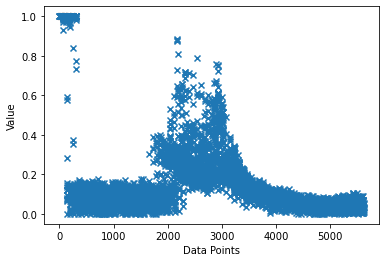

Min Value: 0.0
Max Value: 1.0


In [12]:
#Convert Image array to np
image_array = np.array(sample_image)

#Plot the image array
print(f"Shape of the image array: {image_array.shape}")
image_array_plot = image_array.flatten()
print(f"We flatten the image array to 1d: {image_array_plot.shape}\nand plot the points on a graph:")
y_axis = np.arange(image_array_plot.shape[0])
plt.scatter(y_axis, image_array_plot, marker = 'x')
plt.xlabel("Data Points")
plt.ylabel("Value")
plt.show()
print(f"Min Value: {image_array_plot.min()}")
print(f"Max Value: {image_array_plot.max()}")


#### Purpose of Normalisation

We can see that for all the data points in our image, the pixel value ranges from 0 to 1. This is due to the normalisation in our preprocessing function, `preprocess()`. The purpose of normalisation is to convert the pixel values of all the different images to the same scale, from 0-255 to a float value between 0-1. 

This ensures that updates made during gradient descent are not dominated by the larger pixel values (255) as compared to the smaller values (0). When the gradient descent is dominated by large values, the updated weight values will oscilate back and forth, causing it to take more steps to reach the optimal point.

By normalising all values to 0-1, we will have a more balanced gradient descent, allowing for faster convergence as well. 

Reference: https://www.youtube.com/watch?v=UIp2CMI0748

#### Printing the image of sample of the data

(75, 75, 1)


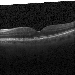

[0 0 1 0]


In [13]:
#Convert the image array back to a format where PIL image reader can understand
image_array_full = image_array * 255
image_array_full = image_array_full.astype(np.uint8)
print(image_array_full.shape)
#Current shape of image is (75,75,1) we squeeze it to get rid of the last channel, making it (75,75)
image_array_full = np.squeeze(image_array_full, axis=2)
im = Image.fromarray(image_array_full)

#Display the image and print the label 
display(im)
tf.print(sample_label)

# Section 4: Building the Model

#### Build Base Model (As defined in the exercise)

In [14]:
cnn_model = tf.keras.models.Sequential()

#First Conv layer
cnn_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation='relu',
                               input_shape=[resize_height,resize_width , 1]))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=4, strides=1))

#Second Conv layer
cnn_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3,strides = 2, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

#Third Conv layer
cnn_model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3,strides = 2, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

#Fully Connected layer
cnn_model.add(tf.keras.layers.Flatten()) #flatten the output from CNN so we can feed it into fully connected layers
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))

#Output layer
cnn_model.add(tf.keras.layers.Dense(4, activation='softmax')) #4 Neurons for 4 output classes


### Checkpoint 3 Display the graph Print out of the model

In [15]:
#tf.keras.utils.plot_model(cnn_model)
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 71, 71, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 68, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

## Section 5: Training

#### Define Loss function and Optimiser

In [16]:
loss_function = 'categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

cnn_model.compile(loss= loss_function, optimizer=optimizer, metrics=['accuracy'])

#Save the initialised weights, it will be used in the subsequent section
cnn_model.save_weights("cnn_init_weights.h5")

### Checkpoint 4: Explain selection of loss function and optimiser

Since we are training a multi-class image classifier model, I will be using `softmax` as the final output layer to obtain the model prediction. The softmax function maps the output of the previous layer onto a set of positive numbers that sum up to one. 

$$p_c(x_i) = \frac{e^{z_c(x_i)}}{\sum_ce^{z_c(x_i)}}$$

As such it can be interpreted as the probability of the image belonging to that particular category. Therefore, the loss function that I will be using is `categorial_crossentropy`. This loss function takes the negative log of the probability that the model predicts for the image.

$$\sum_{c=1}^{C} -y_{i,c}log(p_c(x_i))$$

For example, if the true label of the image is CNV, the loss function takes the negative log of the probability the model predicted for this image to be classified under CNV. If the probability is high (close to 1), the resultant value of the loss function is small (close to 0), else if the probability is very low (close to 1), the resultant value of the loss function will be very large. 

For the optimizer, I was initially planning to use `SGD`. Stochastic Gradient Descent is a good optimizer for image classification models as we are able to make use of the loss calculated by the `categorical_crossentropy` loss function and perform gradient descent to achieve the minimum loss. During the gradient descent, the optimizer performs backpropagation along the neural network and update the filter kernels accordingly. The `SGD` optimizer will allow us to converge at a local minima where the kernel values are trained and updated such that it can now identify the essential features that allow the model to obtain the lowest loss, and hence highest accuracy.

In the end, I decided to go with the `Adam` optimzer as it is a variant of `SGD` and research has been shown that it performs better than the normal `SGD` optimizer in medical image classification task.

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7407771/

#### Define Training/Testing Function here

In [17]:
#Function to train the model
#
#Inputs: 
#    model - Keras Model object to be train
#    train_dataset - tf.Dataset object that contains the training data and labels
#    val_dataset - tf.Dataset object that contains the validation data and labels
#    epochs - python int value of the number of epochs to train the model on
#    callbacks - python list containing keras callback objects to be implemented during training
#
#Outputs:
#    model - Keras Model object that has been trained
#    history - Keras History object

def train_model(model, train_dataset, val_dataset, epochs, callbacks = []):
    if len(callbacks) == 0:
        history = model.fit(train_dataset, validation_data = val_dataset, epochs = epochs, verbose = 1)
    else:
        history = model.fit(train_dataset, validation_data = val_dataset, epochs = epochs,
                            verbose = 1, callbacks = callbacks)
    return model, history


#Function to test the model
#
#Inputs:
#    model - Keras Model object to be tested
#    test_dataset - tf.Dataset object containing the testing data and labels
#
#Output:
#    result - Python list containing the performance of the model on the testing data

def test_model(model, test_dataset):
    result = model.evaluate(test_dataset)
    return result


#Function to plot the performance graph
#
#Inputs:
#    metrics - Python list containing arrays of values to be individually plotted
#    title - Python String for the title of the graph
#    xlabel - Python string for the label of the x-axis
#    ylabel - Python string for the label of the y-axis
#    legend - Python list containing Strings to be used as the legend. Order should follow that of metrics

def performance_graph(metrics, title = None, xlabel = None, ylabel = None, legend = []):
    if title != None:
        plt.title(title)
    if xlabel != None:
        plt.xlabel(xlabel)
    if ylabel != None:
        plt.ylabel(ylabel)
    if len(legend) != 0:
        for metric, label in zip(metrics, legend):
            plt.plot(metric, label = label)
        plt.legend(loc = 'best')
    else:
        for metric in metrics:
            plt.plot(metric)
    plt.show()

### Checkpoint 5: Display training loss-epoch graph


In [18]:
#Initialise Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
mc = tf.keras.callbacks.ModelCheckpoint('best_cnn_weights.h5', monitor='val_accuracy', save_best_only=True,
                                       save_weights_only = True)

#Train the model
trained_cnn_model, cnn_history = train_model(cnn_model, train_dataset, val_dataset, epochs = 50
                                         , callbacks = [es,mc])

#Load the best weights
trained_cnn_model.load_weights('best_cnn_weights.h5')

Epoch 1/50
110/110 [==============================] - 31s 142ms/step - loss: 1.3098 - accuracy: 0.3281 - val_loss: 1.1138 - val_accuracy: 0.4560
Epoch 2/50
110/110 [==============================] - 28s 140ms/step - loss: 1.0079 - accuracy: 0.5519 - val_loss: 0.7949 - val_accuracy: 0.6553
Epoch 3/50
110/110 [==============================] - 29s 143ms/step - loss: 0.7825 - accuracy: 0.6818 - val_loss: 0.7753 - val_accuracy: 0.6807
Epoch 4/50
110/110 [==============================] - 29s 144ms/step - loss: 0.7052 - accuracy: 0.7123 - val_loss: 0.6171 - val_accuracy: 0.7487
Epoch 5/50
110/110 [==============================] - 30s 146ms/step - loss: 0.5939 - accuracy: 0.7726 - val_loss: 0.6064 - val_accuracy: 0.7593
Epoch 6/50
110/110 [==============================] - 30s 148ms/step - loss: 0.5857 - accuracy: 0.7652 - val_loss: 0.7017 - val_accuracy: 0.6893
Epoch 7/50
110/110 [==============================] - 31s 152ms/step - loss: 0.5630 - accuracy: 0.7761 - val_loss: 0.4387 - val_ac

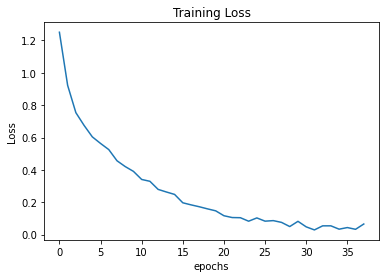

In [19]:
performance_graph(metrics = [cnn_history.history['loss']],
                  title = "Training Loss", xlabel = 'epochs', ylabel = 'Loss')

#### Abnormalities

One abnormality I faced during the training of the model was that the training loss fluctuates up and down quite a bit. I learnt that a possible reason for the fluctuation was that my initial `learning_rate` for the `Adam` optimizer was too high at `2`. I reduced the `learning_rate` back down to the default of `0.001` and the graph of the training loss became more smooth

## Section 6: Validation

In [20]:
#Testing the model on the test_dataset
val_results = test_model(trained_cnn_model, test_dataset)

24/24 [==============================] - 17s 7ms/step - loss: 0.0188 - accuracy: 0.9967


### Checkpoint 6: Display Accuracy-epoch graph

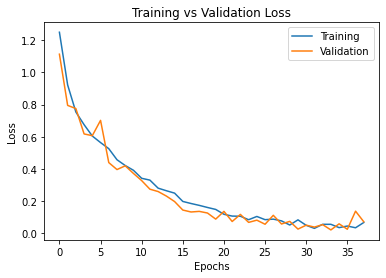

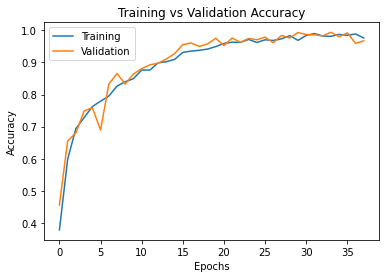

Accuracy on validation set: 0.9940000176429749
Accuracy on test set: 0.996666669845581


In [21]:
#Plot performance graphs
performance_graph(metrics = [cnn_history.history['loss'], cnn_history.history['val_loss']]
                  , title = "Training vs Validation Loss", xlabel = "Epochs",
                  ylabel = "Loss", legend = ["Training", "Validation"])

performance_graph(metrics = [cnn_history.history['accuracy'], cnn_history.history['val_accuracy']]
                  , title = "Training vs Validation Accuracy", xlabel = "Epochs",
                  ylabel = "Accuracy", legend = ["Training", "Validation"])

print(f"Accuracy on validation set: {max(cnn_history.history['val_accuracy'])}")
print(f"Accuracy on test set: {val_results[1]}")

#### Abnormalities

During the intial training and validation (testing) stages, I realised that the model was overfitting on the training data as the validation (testing) accuracy was much lower than the training accuracy. In order to mitigate this problem, I decided to split my dataset into training, validation and testing sets instead of just having a training and test set. During the training of the model, after each epoch, I test the model on the new validation set. I implemented `early_stopping` which will halt the training process if the validation accuracy does not increase after 5 consecutive epochs. This is to prevent overfitting. 

## Section 7: Building a Transfer Model

### Checkpoint 7: Define and explain the choice of transfer base model for transfer learning

**Important Comment**  
The VGG, RESNET and Inception transfer models require an input channel of 3. Since the medical images are greyscale, we need to convert it from a single channel to 3 channels in order to feed it into the transfer models. My solution involves feeding our single-channel images into a `conv2d` layer before feeding the output of that convlution layer into the transfer model. 

This `conv2d` layer will have 3 kernels to get the 3 channel output and the kernel weights are set to a value of 1 with a filter size of 1x1 and a step size of 1 to ensure that the pixel values of the images are not modified before they are fed into the transfer model. The `trainable` attribute is also set to `False` to ensure the these pre-set weights are not updated during the training of the entire model. The `padding` attribute is set to `same` to ensure that the height and width dimension of the input is not modified in this `conv2d` layer. 

**tldr:** The purpose of the `conv2d` layer is to takes in the image tensor of size (75,75,1) and output a tensor of size (75,75,3) such that it can be fed into the transfer model.

Inspiration: https://stackoverflow.com/a/59959369

In [22]:
#Uncomment the following 2 lines if you get a ssl error while trying to download the Resnet imagenet weights
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context


#Creating our conv2d layer
custom_conv_tensor = tf.keras.layers.Input(shape=(resize_height,resize_width,1))
custom_conv = tf.keras.layers.Conv2D(filters=3, kernel_size=1,strides =1,
                                    kernel_initializer = tf.keras.initializers.Ones(), padding = 'same')
custom_conv.trainable = False

#Initialise the Resnet model
transfer_tensor = tf.keras.layers.Input(shape=(resize_height,resize_width,3))
resnet_model = tf.keras.applications.ResNet50V2(include_top = False, weights = "imagenet",
                                                  input_tensor = transfer_tensor)

#Defining the inputs to the various layers
custom_conv_output = custom_conv (custom_conv_tensor)
resnet_model_output = resnet_model (custom_conv_output)
pooling_output = tf.keras.layers.GlobalAveragePooling2D()(resnet_model_output) #custom pooling layer
transfer_model_output = tf.keras.layers.Dense(4, activation = 'softmax')(pooling_output) #custom output layer

#Initialise our transfer_model
transfer_model = tf.keras.models.Model(custom_conv_tensor, transfer_model_output)
#For some strange reason, this model performs horribly when using the Adam optimizer instance defined above for the base cnn model
transfer_model.compile(loss= loss_function, optimizer='adam', metrics=['accuracy'])

#### Rationale for ResNet Model
Upon conducting further research on the VGG, RESNET and Inception models, I learnt that these three models all tries to improve on the traditional CNN architecture in different ways.

**VGG**: Reduce the number of parameters in a traditional CNN model and thus improve training time

**RESNET**: To allow the model to find simpler feature mappings if it exists and to solve the degradation problem that arises as we stack more layers on the CNN architecture. 

**Inception**: Solves the problem of needing to set a fixed kernel size when setting up the model. Inception implements multiple kernels of different sizes within the same layer, allowing for more effective recognition of variable-sized features.

Since we are training a medical image classifier, I decided to go with the ResNet model as I felt that the shorter training times achieved by the VGG is not the primary objective of this classifier. Furthermore, ResNet has more layers and yet lesser number of parameters which takes away one of the benefits of VGG. Inception model brings along the benefit of having more effective recognition of variable-sized features which I feel is not important for this use case. Even though the features to be identified might vary according to the individuals' age, obsesity or even severity of the condition, I feel that the feature sizes will not have such extreme variation in sizes that justify the use of the Inception model.

In my opinion, the primary objective of this classifier would be to pick up important features that can help the model differentiate between the CNV, DME, Drunsen and normal conditions. Using Resnet allows us to train a deeper model without having to worry about the degradation problem. A deeper model will be more likely to identify high-level features that can be used to differentiate between the 4 conditions in this OCT scan, thus allowing for higher accuracy level to be achieved. 


With that being said, it might be possible to achieve the best of both worlds (in terms of identifying important features and effective recognition of variable-sized features) by using InceptionResNet model. However, since it is not one of the models provided in this problem, I shall stick to the ResNet model. 

Reference: https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96

### Checkpoint 8: Display graph printout of the base model with the OCT image classication extension

In [23]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 75, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 3)         6         
_________________________________________________________________
resnet50v2 (Functional)      (None, 3, 3, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 8196      
Total params: 23,573,002
Trainable params: 23,527,556
Non-trainable params: 45,446
_________________________________________________________________


### Checkpoint 9: The training data currently being used is simple and as such transfer learning isn't as advantageous, however some observations can be made when comparing the first model with the second, discuss these observation.

In [24]:
#Train the transfer model
#Due to the large fluctuations in val accuracy in the more complex resnet model, I allow for a higher patience value to ensure
#we dont prematurely end the training
es_resnet = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('best_transfer_weights.h5', monitor='val_accuracy', save_best_only=True,
                                       save_weights_only = True)
trained_transfer_model, transfer_history = train_model(transfer_model, train_dataset, val_dataset, epochs = 50,
                                  callbacks = [es_resnet,mc])

trained_transfer_model.load_weights('best_transfer_weights.h5')


Epoch 1/50
110/110 [==============================] - 48s 246ms/step - loss: 1.0483 - accuracy: 0.5485 - val_loss: 2.4858 - val_accuracy: 0.5967
Epoch 2/50
110/110 [==============================] - 44s 235ms/step - loss: 0.4045 - accuracy: 0.8450 - val_loss: 1.2080 - val_accuracy: 0.6727
Epoch 3/50
110/110 [==============================] - 44s 237ms/step - loss: 0.3507 - accuracy: 0.8673 - val_loss: 0.5578 - val_accuracy: 0.8033
Epoch 4/50
110/110 [==============================] - 43s 228ms/step - loss: 0.2705 - accuracy: 0.9055 - val_loss: 0.3255 - val_accuracy: 0.8753
Epoch 5/50
110/110 [==============================] - 42s 228ms/step - loss: 0.2308 - accuracy: 0.9177 - val_loss: 0.6823 - val_accuracy: 0.7840
Epoch 6/50
110/110 [==============================] - 43s 233ms/step - loss: 0.2093 - accuracy: 0.9214 - val_loss: 0.3142 - val_accuracy: 0.8900
Epoch 7/50
110/110 [==============================] - 43s 231ms/step - loss: 0.1870 - accuracy: 0.9335 - val_loss: 0.1953 - val_ac

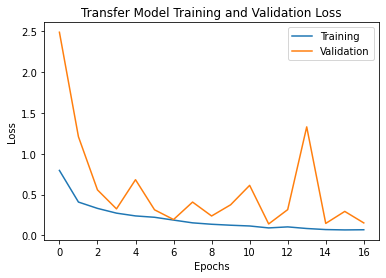

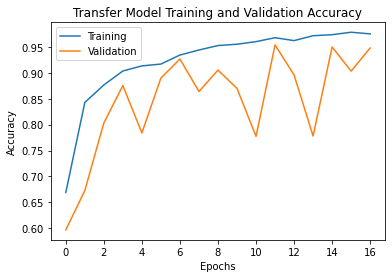

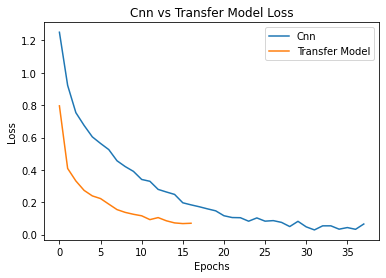

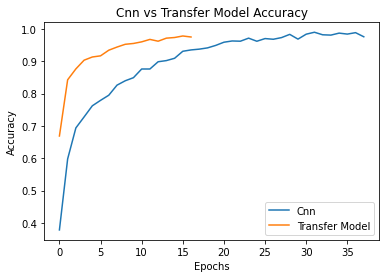

In [25]:
#Plot performance graphs
performance_graph(metrics = [transfer_history.history['loss'], transfer_history.history['val_loss']],
                  title = "Transfer Model Training and Validation Loss", xlabel = "Epochs", ylabel = "Loss",
                 legend = ['Training', 'Validation'])

performance_graph(metrics = [transfer_history.history['accuracy'], transfer_history.history['val_accuracy']],
                  title = "Transfer Model Training and Validation Accuracy", xlabel = "Epochs", ylabel = "Accuracy",
                 legend = ['Training', 'Validation'])

performance_graph(metrics = [cnn_history.history['loss'], transfer_history.history['loss']],
                  title = "Cnn vs Transfer Model Loss", xlabel = "Epochs", ylabel = "Loss",
                 legend = ['Cnn', 'Transfer Model'])


performance_graph(metrics = [cnn_history.history['accuracy'], transfer_history.history['accuracy']],
                  title = "Cnn vs Transfer Model Accuracy", xlabel = 'Epochs', ylabel = 'Accuracy',
                 legend = ['Cnn', 'Transfer Model' ])


In [26]:
#Test the transfer model
transfer_val_results = test_model(trained_transfer_model, test_dataset)

print(f"Cnn Accuracy on validation set: {max(cnn_history.history['val_accuracy'])}")
print(f"Cnn Accuracy on test set: {val_results[1]}")
print(f"Transfer Model Accuracy on validation set: {max(transfer_history.history['val_accuracy'])}")
print(f"Transfer Model Accuracy on test set: {transfer_val_results[1]}")

24/24 [==============================] - 18s 21ms/step - loss: 0.1101 - accuracy: 0.9620
Cnn Accuracy on validation set: 0.9940000176429749
Cnn Accuracy on test set: 0.996666669845581
Transfer Model Accuracy on validation set: 0.9539999961853027
Transfer Model Accuracy on test set: 0.9620000123977661


#### Observations

First observation I made was that the validation loss and validation accuracy of the transfer model seem to have very severe fluctuations as compared to that of the normal cnn model. This can be seen in the `Transfer Model Training and Validation Accuracy` and `Transfer Model Training and Validation Loss` graph shown above. A possible reason for this is due to the high complexity of the resnet model and the small amount of training data that we have. As such, the model tends to overfit more frequently and easily to the training data which could explain the large drop in validation accuracy. 

The second observation I made was that the transfer model was able to fit the training data a lot quicker than the base Cnn model. This can be seen in the `Cnn vs Transfer Model Loss` and `Cnn vs Transfer Model Accuracy` graph, where the trasfer model is able to achieve lower loss and higher accuracy faster than the base Cnn model. This could be due to the loading of imagenet weights on the transfer model, allowing the model to already identify low level filters, giving it a headstart as compared to the base Cnn model.


The last observation made is that, most of the time, the base Cnn model seems to be able to outperform the transfer model. However, there are rare cases where the the transfer model is able to perform better than the base Cnn model. Even when the transfer model does not perform better than the base Cnn model, it is able to come very close to it and also reach that performance level faster as well. Perhaps if we are given a larger dataset, or if we are able to add and find the optimum regluarization parameters, I feel that the transfer model will be able to outperform the base Cnn model

### Checkpoint 10: Discuss why this may not be favourable and the problems it presents. 


Having an under-represenation of the CNV class is not favourable for the following 2 reasons:

1) The small number of CNV images might not provide  enough samples for the image classifier to learn the correct kernel filters to pick up the identifying features. 

2) The dataset having signifcantly more images in the other three categories will result in the kernel filter weights being updated to identify the features of those three categories more frequently as compared to the CNV category. As such, the trained classifier will be more bias towards classifying images into the Drunsen, DME and Normal category instead of CNV.

This will cause a problem where the image classifier will not be able to correctly and effectively classify images under the CNV category and it might wrongly classify CNV images into the other three categories instead

### Checkpoint 11: Show some methods that can be utilised to negate or minimise these effects. Compare the accuracy and explain the pros and cons of these techniques (If any) 

The possible methods to minimise the effects of class imbalance are:
1. **Undersampling** - Remove some images from the over-represented set so as to make the classes more balanced
    - Pros: Able to easily solve the imbalance issue
    - Cons: The reduction will result in less training data and as such the model might not be able to learn the necessary features to effective identify these classes
    
2. **Oversampling** - Increase the size of the under-represented class by making copies of the images under that class
    - Pros: Able to solve the imbalance issue without sacrificing the data from the other classes
    - Cons: Copying the images does not provide any "new" data for the model to learn from and might cause the model to overfit 
    
3. **Image Augmentation** - Increase the size of the under-represented class by performing image augmentation (rotation, shear, mirroring, etc.)
    - Pros: Able to solve the imbalance issue without sacrificing the data from the other classes and the mild noise added during image augmentation can help prevent overfitting
    - Cons: Hard to determine to what degree the augmentation should be done


For this specific case of medical image classifications, I decided to go with **oversampling** to mitigate this issue. 

**Undersampling**
Considering that we already have very little training data, I do not think its a good idea to go with undersampling and further reduce the size of our training set. 

**Image Augmentation**
Image augmentation would typically be a good way to deal with this problem. However, for medical image classification, I feel that it would not be so good. We should not augment the training data to the point where it is not plausible for such an image to be seen in the test set. For medical images, I feel that the images produced are always very consistent. I do not think that we will have any OCT scans with geometric distortions such as rotation, mirroring or shear effects, and neither will we have any photometric distortions such as contrast and gamma changes. Thus I feel that image augmentation might not be good for our use case

Therefore I decided to go with oversampling. By increasing the size of the CNV training set by making copies, though we do not feed the model with new data, I feel that we should at least be able to tackle the **bias** problem mentioned above. In order to combat overfitting, instead of increasing the size of the CNV training set to be the same as the other three classes, I decided to increase it by just a small number, from 700 to 800 images in the training set. Thus, only **0.1** of our entire CNV set will be copied.

Reference: https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6

In [27]:
#Create a new dataset to store the cnv images filenames used for oversampling
oversample_cnv_filenames_dataset=tf.data.Dataset.list_files("Data/CNV/*.jpeg", shuffle = True)
#Retrieve the images and preprocess it
pf = partial(preprocess,label = "CNV", width = resize_width, height = resize_height, encoder = encoder)
oversample_cnv_image_dataset = oversample_cnv_filenames_dataset.map(pf)


#Take 0.3 of the CNV images to be used for oversampling
oversample_img_datasets = [oversample_cnv_image_dataset]
oversample_dataset_sizes = [size["CNV"]]

_,_, oversample_dataset = split_dataset(oversample_img_datasets, oversample_dataset_sizes,
                                                        val_size = 0.3, test_size = 0.1)

#Add the oversample images to our original training dataset
#oversample_train_dataset is a copy of the original train_dataset
oversample_train_dataset = oversample_train_dataset.concatenate(oversample_dataset)

#Shuffle and batch
oversameple_train_dataset = oversample_train_dataset.shuffle(10000)
oversample_train_dataset = oversample_train_dataset.batch(batch_size)
oversample_train_dataset = oversample_train_dataset.prefetch(1)

In [28]:
#Initialise model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint('best_oversample_weights.h5', monitor='val_accuracy', 
                                        save_best_only=True, save_weights_only = True)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
#load back the orginal initialised weights
cnn_model.load_weights('cnn_init_weights.h5')



#Train the model using oversampling
oversample_trained_cnn_model, oversample_cnn_history = train_model(cnn_model, oversample_train_dataset
                                                                   ,val_dataset, epochs = 50, callbacks = [es,mc])

#load best weights
oversample_trained_cnn_model.load_weights('best_oversample_weights.h5')



Epoch 1/50
111/111 [==============================] - 38s 192ms/step - loss: 1.2951 - accuracy: 0.3506 - val_loss: 1.3200 - val_accuracy: 0.3867
Epoch 2/50
111/111 [==============================] - 39s 192ms/step - loss: 1.2877 - accuracy: 0.3899 - val_loss: 1.2448 - val_accuracy: 0.4267
Epoch 3/50
111/111 [==============================] - 39s 193ms/step - loss: 1.1089 - accuracy: 0.5014 - val_loss: 3.4377 - val_accuracy: 0.1087
Epoch 4/50
111/111 [==============================] - 39s 197ms/step - loss: 1.0372 - accuracy: 0.5577 - val_loss: 1.4319 - val_accuracy: 0.3487
Epoch 5/50
111/111 [==============================] - 40s 198ms/step - loss: 0.8555 - accuracy: 0.6356 - val_loss: 1.0557 - val_accuracy: 0.5540
Epoch 6/50
111/111 [==============================] - 40s 200ms/step - loss: 0.7697 - accuracy: 0.6808 - val_loss: 1.1123 - val_accuracy: 0.5200
Epoch 7/50
111/111 [==============================] - 40s 195ms/step - loss: 0.7065 - accuracy: 0.7120 - val_loss: 0.8621 - val_ac

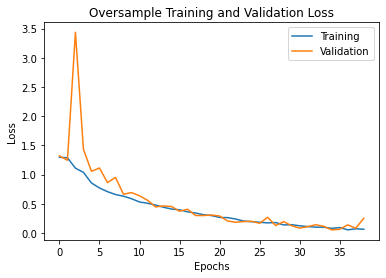

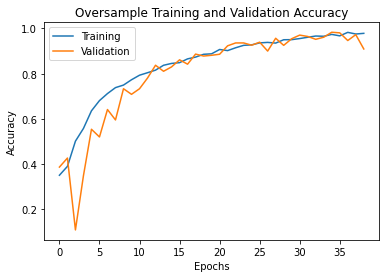

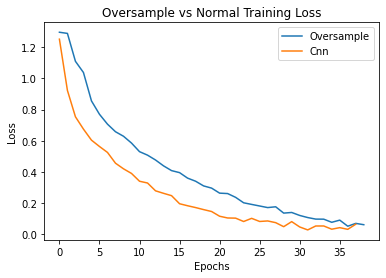

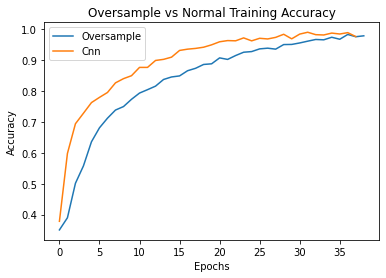

In [29]:
#Plot performance graphs
performance_graph(metrics = [oversample_cnn_history.history['loss'], oversample_cnn_history.history['val_loss']]
                  , title = "Oversample Training and Validation Loss",
                  xlabel = "Epochs", ylabel = "Loss", legend = ['Training', 'Validation'])

performance_graph(metrics = [oversample_cnn_history.history['accuracy'], oversample_cnn_history.history['val_accuracy']]
                  , title = "Oversample Training and Validation Accuracy",
                  xlabel = "Epochs", ylabel = "Accuracy", legend = ['Training', 'Validation'])

performance_graph(metrics = [oversample_cnn_history.history['loss'], cnn_history.history['loss']]
                  , title = "Oversample vs Normal Training Loss",
                  xlabel = "Epochs", ylabel = "Loss", legend = ['Oversample', 'Cnn'])

performance_graph(metrics = [oversample_cnn_history.history['accuracy'], cnn_history.history['accuracy']],
                  title = "Oversample vs Normal Training Accuracy",
                  xlabel = 'Epochs', ylabel = 'Accuracy', legend = ['Oversample', 'Cnn'])

In [30]:
#Test the model
oversample_val_results = test_model(oversample_trained_cnn_model, test_dataset)

print(f"Normal Accuracy on validation set: {max(cnn_history.history['val_accuracy'])}")
print(f"Normal Accuracy on test set: {val_results[1]}")
print(f"Oversample Accuracy on validation set: {max(oversample_cnn_history.history['val_accuracy'])}")
print(f"Oversample Accuracy on test set: {oversample_val_results[1]}")

24/24 [==============================] - 18s 7ms/step - loss: 0.0598 - accuracy: 0.9833
Normal Accuracy on validation set: 0.9940000176429749
Normal Accuracy on test set: 0.996666669845581
Oversample Accuracy on validation set: 0.9833333492279053
Oversample Accuracy on test set: 0.9833333492279053


The performance of the oversampled Cnn model compared to the base Cnn model is not really conclusive. On some runs, the oversampled Cnn model performs better while on other runs the base Cnn model performs better. However, the scores between the two models are usually very similar. Therefore, based on the accuracy and loss scores alone, we cant conclude for sure that the oversampling method is able to mitigate the problem of class imbalance in this use case.  

A possible explanation for the base Cnn model performing better could be due to the test and validation dataset still having higher proportion of the other 3 classes. Thus when more CNV class images are introduced through oversampling, the model becomes less bias towards the other 3 classes. As a result, the oversampled model sometimes performs slighty worse than the normal model on the test and validation set.

A possible extension to this assignment to validate this hypothesis could be to perform class-wise accuracy, allowing us to measure the accuracy of the model for all four classes separately. If the performance on the CNV class is better when tested on the oversampled model as compared to the normal model, it would prove that this oversampling method is successful in minimising the effects of imbalanced class size for our use case.